In [39]:
import tensorflow as tf
from keras.layers import Input, Reshape, Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import matplotlib.pyplot as plt
from keras.datasets import mnist
import numpy as np
from scipy.spatial import distance

from keras.utils import np_utils
from keras.datasets import mnist

seed = 1111
np.random.seed(seed)
tf.random.set_seed(seed+1)



# Download and visualize the MNSIT datset

First of all we download the mnist dataset. Because each image is represented with a 28x28 array with values in [0,255] we need to rescale values in [0,1] by diving each vector by 255

In [50]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255

Now we visualize 10 images, 2 rows and 5 columns. For each image we generate a subplot

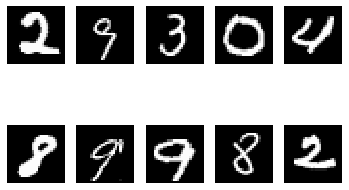

In [43]:
rows = 2
cols = 5

mnist_batch = x_train[np.random.choice(x_train.shape[0], rows*cols, replace=False)]

for idx,mnist_img in enumerate(mnist_batch):
    plt.subplot(rows, cols, idx+1)
    plt.axis(False)
    plt.imshow(mnist_img.reshape(28,28), cmap='gray') 
    
plt.show()

# Data augmentation

Mnist has already lot of different examples, so a step of data augmentation is not strictly needed. However in many cases data augmentation is very important and helps make the nn more robust, so it is interesting to see it.

In [41]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2)
datagen.fit(x_train)

We visualize the augmentation relation in one batch of 10 examples

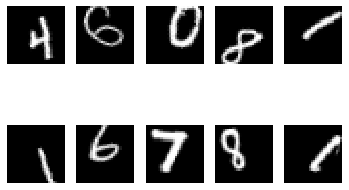

In [44]:
rows = 2
cols = 5
batch = next(datagen.flow(x_train, Y_train, batch_size=(rows*cols)))[0]

for idx,augm_img in enumerate(batch):
    plt.subplot(rows, cols, idx+1)
    plt.axis(False)
    plt.imshow(augm_img.reshape(28,28), cmap='gray') 
    
plt.show()

# One hot encoding

In the last layer we will have the probabilities of each number. So, before start training we need to convert the target output to one-hot encoding

In [57]:
nclasses = 10

print(f"Shape before one-hot encoding: {y_train.shape} \n\ty_train[0]-> {y_train[0]}")
Y_train = np_utils.to_categorical(y_train, nclasses)
Y_test = np_utils.to_categorical(y_test, nclasses)
print(f"Shape after one-hot encoding: {Y_train.shape} \n\tY_train[0]-> {Y_train[0]}")

Shape before one-hot encoding: (60000,) 
	y_train[0]-> 5
Shape after one-hot encoding: (60000, 10) 
	Y_train[0]-> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# Architecture and fit

The other renderings are done with http://alexlenail.me/NN-SVG/LeNet.html

In [63]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
out = Dense(10, activation='softmax')(x)

cnn = Model(input_img, out)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(cnn, to_file='cnn_rendering/keras_plot.png',show_shapes=True);

In [59]:
EPOCHS = 2
BATCH_SIZE = 32
STEPS_EPOCH = len(x_train) / BATCH_SIZE
history = cnn.fit_generator(datagen.flow(x_train, Y_train, batch_size=BATCH_SIZE),
                  shuffle=True,
                  validation_data=datagen.flow(x_test, Y_test, batch_size=BATCH_SIZE),
                  steps_per_epoch=STEPS_EPOCH, epochs=EPOCHS).history

Epoch 1/2
1875/1875 [==============================] - 63s 33ms/step - loss: 0.6754 - accuracy: 0.7854 - val_loss: 0.2749 - val_accuracy: 0.9063
Epoch 2/2
1875/1875 [==============================] - 78s 42ms/step - loss: 0.2967 - accuracy: 0.9115 - val_loss: 0.0687 - val_accuracy: 0.9323


# Pitasi

In [34]:
from ipycanvas import Canvas
from math import pi

import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Clear")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    canvas.clear()
    
canvas = Canvas(size=(420, 420), sync_image_data=True)

def handle_mouse_move(x, y):
    global mouse_down
    if mouse_down:
        canvas.fill_style = 'black'
        canvas.stroke_style = 'black'
        canvas.fill_arc(x, y, 2, 0, 2 * pi)

def handle_mouse_down(x, y):
    global mouse_down
    mouse_down = True

def handle_mouse_up(x, y):
    global mouse_down
    mouse_down = False

canvas.on_mouse_move(handle_mouse_move)
canvas.on_mouse_down(handle_mouse_down)
canvas.on_mouse_up(handle_mouse_up)

button.on_click(on_button_clicked)

canvas

Button(description='Clear', style=ButtonStyle())

Output()

AttributeError: 'Canvas' object has no attribute 'height'

3


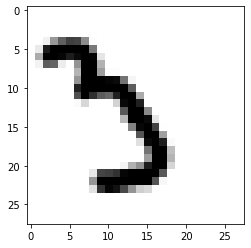

In [30]:
import cv2
import matplotlib.pyplot as plt
    
arr1 = canvas.get_image_data()
usample = cv2.resize(arr1, dsize=(28, 28), interpolation=cv2.INTER_AREA) / 255 

plt.imshow(usample)

usample = np.apply_along_axis(lambda x: max(x), 2, usample)
prediction = cnn.predict(usample.reshape(1,28,28,1))
print(np.argmax(prediction[0]))